In [398]:
from CSOWP_SR import *
from ExpressionTree import *
from trainAlgorithm import *
import matplotlib.pyplot as plt
import pandas as pd
import graphviz
from re import sub
import numpy as np

plt.rcParams.update({"text.usetex": True})


def least_squares(y, y_pred):
    return np.mean( (y-y_pred)**2 )

def getSmpTreeGraph(sexp, img_path=None):
    
    for i in smp.preorder_traversal(sexp):
        if isinstance(i, smp.Float):
            sexp = sexp.subs(i, round(i, 2))
    
    s = smp.printing.dot.dotprint(sexp).replace("Add", "+").replace("Mul", "*")
    s = sub('0+(?=")', "0", s)
    
    if img_path is None:
        s = graphviz.Source(s)
    else:
        s = graphviz.Source(s, filename=img_path+".gv", format="png")
        s.render()
    
    return s


def runTests(X, y, dir_path, operators, functions, feature_names, cleaned_data="results.csv",
            real_func_string=None, seaborn=False):
    
    # Setup =========================================================================
    if real_func_string is None:
        real_func_string = "Real"
    else:
        real_func_string = fr"Real - ${real_func_string}$"
    
    if seaborn==True:
        import seaborn as sns
        sns.set()
    
    title = dir_path[dir_path.find("/")+1:]
    
    
    # Loading Data ====================================================================
    data = pd.read_csv(dir_path + "/" + cleaned_data)
    best_tree = data.sort_values("fitness_score", axis=0)
    best_tree = best_tree.reset_index(drop=True)
    
    best_population = str(best_tree.population[0])
    best_generation = str(best_tree.generations[0])
    best_time = best_tree.training_time[0]/60.0
    best_fitness = best_tree.fitness_score[0]
    
    img_path = dir_path + "/trees/tree-" + best_population + "-" + best_generation
    
    with open(img_path, "rb") as file:
        best_tree = pickle.load(file)
    
    func, sexp = best_tree.toFunc(operators, functions, feature_names, inv_data = {
        "Xmin": X.min(),
        "Xmax": X.max(),
        "ymin": y.min(),
        "ymax": y.max()
    })
    
    
    x_range = X.max() - X.min()
    y_range = y.max() - y.min()
    
    
    plot_sexp = sexp
    for i in smp.preorder_traversal(plot_sexp):
            if isinstance(i, smp.Float):
                plot_sexp = plot_sexp.subs(i, round(i, 2))
    
    
    s = getSmpTreeGraph(sexp, img_path)
    
    
    # 2 curves Plot =========================================================================
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [4, 1]})
    
    
    ax=axs[0]
    
    ax.set_title(r"Real Function X Predicted Function - " + f"{title}", fontsize=14)
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    
    pred_label = smp.latex(plot_sexp)
    pred_label = sub("operatorname", "mathrm", pred_label)
    
    ax.plot(X, y, label=real_func_string) 
    ax.plot(X, func(X), label=fr"Predicted - ${pred_label}$")
    ax.legend(fontsize=14, loc="upper left")
    
    
    ax = axs[1]
    ax.annotate(f"""Training Time: {best_time:.2f} minutes
        Normalized Fitness Score: {best_fitness:.2E}
        Real Fitness Score: {least_squares(y,func(X)):.2E}
        Population Size: {best_population}""", 
            (-x_range/X.max()/3, ax.get_ylim()[1]-1.7/y_range), bbox={"facecolor": "lightgray", "edgecolor": "black"},
            linespacing = 1.5, annotation_clip=False)
    
    # ins = plt.gca().inset_axes([0.5, 0.05, x_range/X.max()/1.8, y_range/y.max()/1.8])
    img = plt.imread(img_path+".gv.png")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor((1,1,1))
    ins = ax.inset_axes([-x_range/X.max()/5, 0, 0.8, 0.8])
    ins.imshow(img)
    ins.get_xaxis().set_visible(False)
    ins.get_yaxis().set_visible(False)
    ins.set_title(f"Output Expression")
    plt.show()

    
    # Least Squares curve ====================================================================
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    

In [395]:
from sklearn.preprocessing import MinMaxScaler

def func(x):
    a=10
    b=-0.5
    c=-0.5
    d=2
    return a*np.exp(b*np.exp(c*x + d))

x_range = (0,15)
n_points = 1000
dir_path = "Outputs/Tests_analysis"
const_range=(-10,10)
population=50
generations=3
max_expression_size=3
normalize=True
n_runs=1

X, y, operators, functions = testAlgorithm(func, x_range, n_points, dir_path, population, generations, 
                  max_expression_size, normalize=True, const_range=const_range,
                  ignore_warning=True, overwrite=True, n_runs=n_runs)

-=-=-=-=-=-=-=-= Training for population 50 and generation 3 - Tests_analysis =-=-=-=-=-=-=-=-
-=-=-=-=-=-=-= Done training for population 50 and generation 3 - Tests_analysis =-=-=-=-=-=-=-


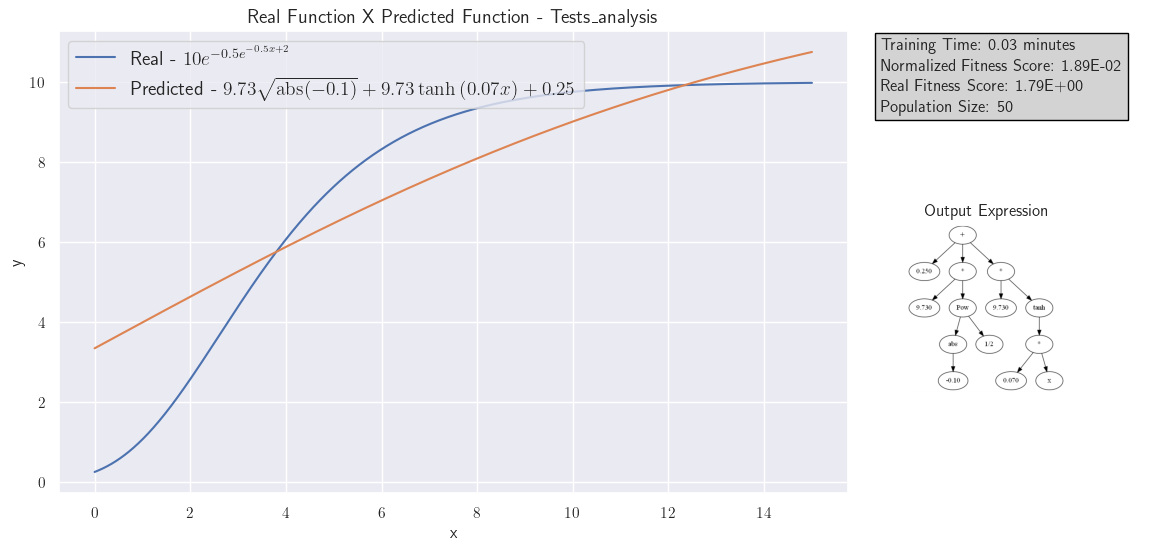

In [396]:
runTests(X, y, dir_path, operators, functions, ["x"], real_func_string=r"10e^{-0.5e^{-0.5x+2}}", seaborn=True)